<a href="https://colab.research.google.com/github/LukeWeidenwalker/ai-notebooks/blob/master/fastai_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook 
fastbook.setup_book()

     |████████████████████████████████| 727kB 15.5MB/s 
     |████████████████████████████████| 1.2MB 54.4MB/s 
     |████████████████████████████████| 194kB 56.5MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *
from fastbook import *
from time import time


In [3]:
torch.random.manual_seed(42);
torch.set_printoptions(sci_mode=False)

In [4]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [6]:
digits = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_items=get_image_files,
                   splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                   get_y=parent_label)

In [7]:
dls = digits.dataloaders(path)

In [8]:
dls.one_batch()[0].shape, dls.one_batch()[1]

((64, 1, 28, 28),
 TensorCategory([7, 0, 5, 7, 1, 7, 9, 8, 0, 9, 0, 5, 5, 7, 1, 7, 5, 5, 0, 1, 3, 5, 6, 8, 7, 4, 9, 2, 4, 4, 4, 5, 0, 8, 7, 1, 7, 3, 1, 3, 4, 8, 0, 0, 8, 4, 1, 4, 1, 7, 9, 5, 5, 4, 2, 0, 5, 5, 4, 5, 8, 8, 5, 8],
        device='cuda:0'))

In [9]:
dls.valid.one_batch()[0][0].shape

(1, 28, 28)

# Model

In [10]:
def softmax(x): 
  return torch.exp(x) / torch.exp(x).sum(dim=1, keepdim=True)

In [11]:
def neg_log_likelihood(x, targ):
  return (-x[range(len(targ)), targ])

In [12]:
def cross_entropy_loss(acts, targ, reduction="mean"):
  preds = torch.log(softmax(acts))
  return neg_log_likelihood(preds, targ).mean() if reduction=='mean' else neg_log_likelihood(preds, targ)

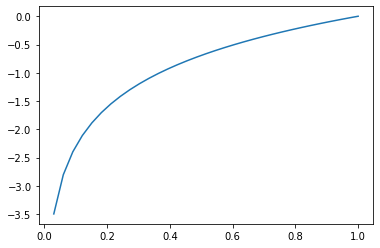

In [87]:
plot_function(torch.log, max=1)

In [77]:
torch.log(tensor(0.6931))

tensor(-0.3666)

In [90]:
t = torch.stack([torch.log(tensor(0.8)), torch.log(tensor(0.6)), torch.log(tensor(0.4)), torch.log(tensor(0.2)), torch.log(tensor(0.1)), torch.log(tensor(0.01)),torch.log(tensor(10.05**-45)), torch.log(tensor(10**-46))])
distances = t.unsqueeze(1) - t; print(distances)
print(distances.diagonal(offset=1))

tensor([[   0.0000,    0.2877,    0.6931,    1.3863,    2.0794,    4.3820,  103.0558,       inf],
        [  -0.2877,    0.0000,    0.4055,    1.0986,    1.7918,    4.0943,  102.7681,       inf],
        [  -0.6931,   -0.4055,    0.0000,    0.6931,    1.3863,    3.6889,  102.3626,       inf],
        [  -1.3863,   -1.0986,   -0.6931,    0.0000,    0.6931,    2.9957,  101.6695,       inf],
        [  -2.0794,   -1.7918,   -1.3863,   -0.6931,    0.0000,    2.3026,  100.9763,       inf],
        [  -4.3820,   -4.0943,   -3.6889,   -2.9957,   -2.3026,    0.0000,   98.6738,       inf],
        [-103.0558, -102.7681, -102.3626, -101.6695, -100.9763,  -98.6738,    0.0000,       inf],
        [     -inf,      -inf,      -inf,      -inf,      -inf,      -inf,      -inf,       nan]])
tensor([ 0.2877,  0.4055,  0.6931,  0.6931,  2.3026, 98.6738,     inf])


This scales in ways I didn't fully appreciate before. So in order to get the loss, we only look at how far off the prediction is for the target class - we don't actually look at any 'wrong' predictions at all, it's more a 'how not right' were you on the prediction that matters. We index to the prediction that should be 1 (because it is the target label) - ff it *is* 1, then the negative log of that will be 0, so the loss will be 0. 

The further the prediction for the target class is from 1, the higher the loss, scaling exponentially as it gets closer to 0 (the total opposite of the right answer). So 'fixing' a prediction from 0.6 to 0.8 saves us from 0.28 loss, but going from 0.4 to 0.6 saves us from 0.69 loss. I'm sure there's a good mathsy way of precisely describing this relationship using the gradient of the log function, but the point is simply that the further the prediction on the target class is from one, the higher the loss per unit of false prediction. So completely wrong guesses will cause a much higher loss than right guesses that are not 100% confident. In training this then has the effect of prioritising the fixing grave mistakes over making predictions more confident. This seems super beneficial, because it allows for the sweet spot where the biggest errors are fixed, but the network is not overconfident yet (which would be dumb, because inference will generally require predictions for a different sample of the problem space than was seen during training).

This is actually quite interesting. Stopping training before the predictions become too overfitted to the training set leads to the phenomenon that even after loads of training, at inference, the model will not give a probability of 1 to an item that it has already seen during training. Is this desirable? As a human, I don't look at an 8 (especially if it's an archetypical 8, I'm not talking about weird edgecases) and saying "Yep, this is an 8 with  99.98% probability!". There's no 0.02% chance that I am completely wrong in my representation of what an 8 is when I make the prediction. I wonder how 

I also thought a bit about boundary conditions. As the input to the log becomes smaller, it approaches infinity. In PyTorch the jump from -103 to -inf happens when going from `log(10.05**-45)` to `log(10.05**-46)`. I wonder if there are any precautions inbuilt against the possible infinite loss when the prediction is sufficiently far from the target.

And again, how lucky that the log exists, because this relationship is not obvious.



I've also had a look at the top reported result for MNIST:

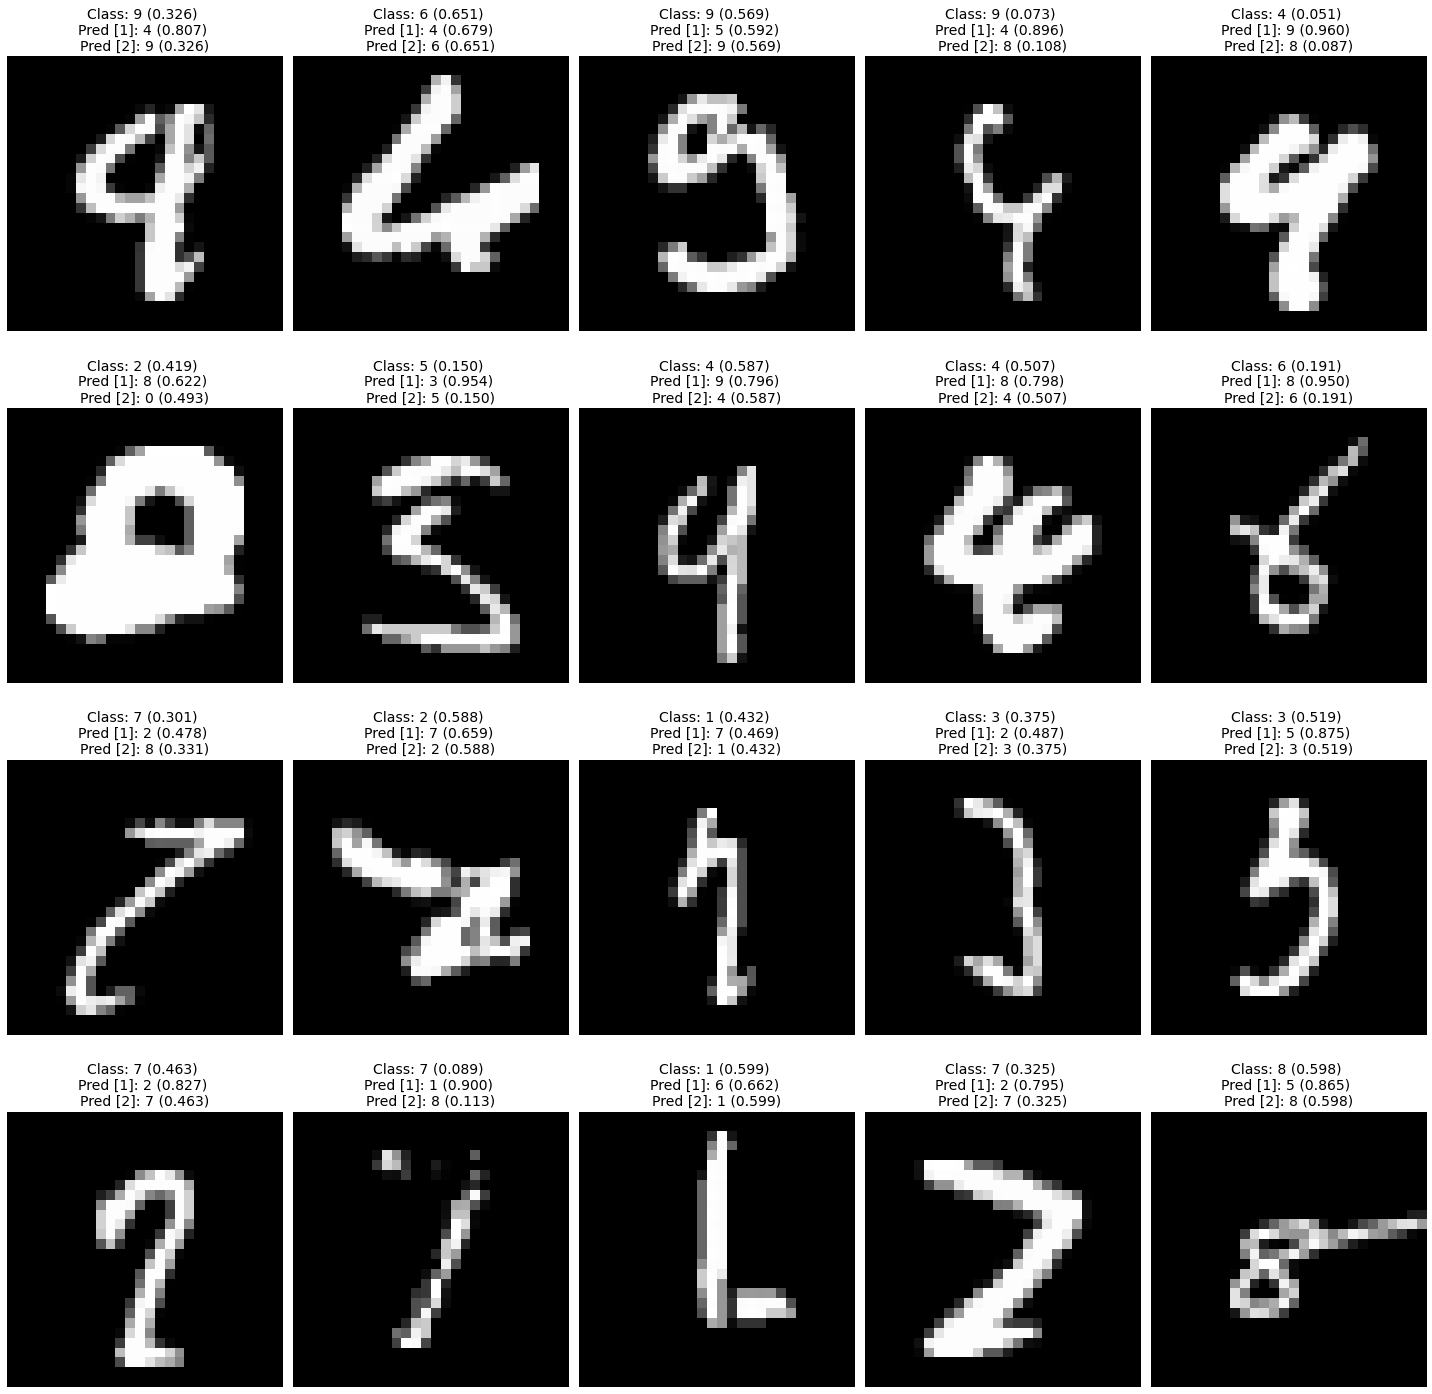

On its own training set it gets these:

------------------------------MNIST Evaluation------------------------------
Test acc: 0.9994333333333333
Test error [%]: 0.0567%
N° misclassified images: 34 out of 60000




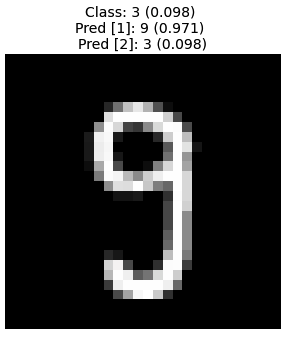

This is one of the examples from the training set which it "gets wrong" when running the evaluation on the training set. On the one hand - great, this is definitely a nine, and it's mislabelled. But then again, the 3% chance that this isn't a nine somehow bothers me. If the concept of nine means anything, that is it. Am I misunderstanding something here? Is the output from the softmax not really to be taken as a literal expression of probability?
I feel like reporting a 0.16% error rate doesn't tell the whole picture here. I'm sure the case with Bayes error (human baseline) has been made, but a smart human makes no mistakes on this dataset, there are just several mistakes in labelling. Wrongly labelled data exaggerates Bayes Error, no?

I mean, I'm sure this is just an extremely specialised task, with a small-ish dataset. I wonder if I'm wrong in thinking that having a 3% residual probablity of this being not a nine tells a different story than the 0.16% error rate.

In [22]:
acts = torch.randn((6,2))*2
log_sm = torch.log(softmax(acts))
target = tensor([0, 1, 1, 0, 0, 1])

print(acts)
print(softmax(acts))
print(torch.log(softmax(acts)))
print(cross_entropy_loss(acts, target, reduction="none"))
print(neg_log_likelihood(acts, target).mean().item(), F.nll_loss(acts, target, reduction='mean').item())
print(cross_entropy_loss(acts, target).mean().item(), F.cross_entropy(acts, target, reduction='mean').item())


tensor([[ 0.1717,  0.3722],
        [ 1.3513,  0.2625],
        [ 0.0363, -4.4997],
        [ 4.2021,  2.8743],
        [-2.5552, -1.2600],
        [ 0.5389,  1.4965]])
tensor([[0.4501, 0.5499],
        [0.7482, 0.2518],
        [0.9894, 0.0106],
        [0.7905, 0.2095],
        [0.2150, 0.7850],
        [0.2774, 0.7226]])
tensor([[-0.7984, -0.5979],
        [-0.2901, -1.3789],
        [-0.0107, -4.5466],
        [-0.2351, -1.5629],
        [-1.5373, -0.2420],
        [-1.2824, -0.3248]])
tensor([0.7984, 1.3789, 4.5466, 0.2351, 1.5373, 0.3248])
0.15368087589740753 0.1536809206008911
1.470194935798645 1.4701951742172241


The torch [docs](https://pytorch.org/docs/stable/nn.functional.html#log-softmax) explain that in practise doing softmax() followed by log() is slower and numerically unstable. Note to myself to checkout F.log_softmax() to see what they are doing differently when I'm further into the course.

In [ ]:
def batch_accuracy(preds, yb):
  preds = preds.argmax(dim=1)
  correct = preds == yb
  return correct.float().mean()

test_xb = tensor([[0.2, 0.2, 0.6], [0.1, 0.8, 0.1], [0.3, 0.3, 0.4]])
test_yb = tensor([2, 1, 0])
batch_accuracy(test_xb, test_yb)

tensor(0.6667)

In [ ]:
class BasicOptimiser:
  def __init__(self, params, lr):
    self.params,self.lr = list(params),lr

  def step(self):
    for p in self.params:
      p.data -= p.grad.data * self.lr

  def zero_grad(self):
    for p in self.params:
      p.grad = None

In [ ]:
class BasicSigmoid:
  def __call__(self, xb):
    return xb.sigmoid()

  def parameters(self):
    return []

In [ ]:
class BasicLearner:
  def __init__(self, dls: DataLoaders, model, opt_func, loss_function, batch_accuracy):
    self.dls = dls # type: DataLoaders
    self.model = model
    self.opt_func = opt_func(model.parameters(), 0.03)
    self.loss_function = loss_function
    self.batch_accuracy = batch_accuracy

  def validate_epoch(self):
    accs = [self.batch_accuracy(self.model(xb), yb) for xb, yb in self.dls.valid]
    return round(torch.stack(accs).mean().item(), 4)

  def fit(self, epochs):
    for epoch in range(epochs):
      accs = []
      start_time = time()
      for xb, yb in self.dls.train:
        preds = self.model(xb)
        loss = self.loss_function(preds, yb)
        loss.backward()
        self.opt_func.step()
        self.opt_func.zero_grad()
      print(f"Epoch {epoch}, Accuracy: {self.validate_epoch()}, took {time() - start_time:.2f}s")

  def pred(self, xb):
    return self.model(xb).argmax(dim=1)

In [ ]:
simple_net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,10)
)
simple_net.to(torch.cuda.current_device())

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)

moving the model to GPU is usually done by fastai 

In [ ]:
learner = BasicLearner(dls, simple_net, BasicOptimiser, cross_entropy_loss, batch_accuracy)
learner.fit(2)

Epoch 0, Accuracy: 0.9068, took 74.17s
Epoch 1, Accuracy: 0.9162, took 72.13s


In [ ]:
valid_im, valid_label = dls.valid.one_batch()[0][4], dls.valid.one_batch()[1][4]
prediction = learner.pred(valid_im)
dls.vocab[prediction], dls.vocab[valid_label]

((#1) ['7'], '7')

# Experiments

What about using the median loss, rather than the mean?

In [ ]:
def mnist_loss_median(preds, target):
  return torch.where(target==1, 1-preds, preds).median()

In [ ]:
model = SimpleNet(28*28, 1)
learner_exp1 = BasicLearner(dls, model, BasicOptimiser(model.parameters(), 0.13), mnist_loss_median, batch_accuracy)
learner_exp1.fit(10)

Epoch 0, Accuracy: 0.5068
Epoch 1, Accuracy: 0.5068
Epoch 2, Accuracy: 0.5068
Epoch 3, Accuracy: 0.5068
Epoch 4, Accuracy: 0.5166
Epoch 5, Accuracy: 0.5552
Epoch 6, Accuracy: 0.6074
Epoch 7, Accuracy: 0.6519
Epoch 8, Accuracy: 0.7769
Epoch 9, Accuracy: 0.8369


Answer: It just trains slower (but still converges at some point in this case)

## Bonus: Weights & Biases